
# HMM + Monte Carlo for Swing Trading (Configurable)

This notebook provides a **clean, modular, and well‑documented** pipeline to:
1. Download price data for a configurable list of tickers.
2. Engineer features for Hidden Markov Model (HMM) regime detection.
3. Fit an HMM to identify latent market regimes (e.g., bull, bear, chop).
4. Profile regimes and choose the most favorable state(s) for going long.
5. Run Monte Carlo (MC) simulations (both simple GBM and regime-aware) to estimate probabilities such as:
   - Probability of hitting a **target** before a **stop** within a given **horizon** (first-passage).
   - Expected return, Value-at-Risk (VaR), and Expected Shortfall (ES).
6. Summarize results per ticker and (optionally) visualize recent price + inferred states.



## 0. Parameters (Edit Me)

Configure **tickers**, **timeframe**, **HMM**, and **Monte Carlo** settings here.


In [25]:

# === User Parameters ===

# Universe of tickers (e.g., NSE symbols with .NS suffix)
TICKERS = ["RELIANCE.NS", "TCS.NS", "INFY.NS"]

# Timeframe
YEARS_BACK = 10                 # how many years of history to download
END_DATE = "2025-09-09"
# START_DATE will be computed from YEARS_BACK below

# Horizon and Risk/Reward for MC (first-passage probabilities)
HORIZON_DAYS = 20             # e.g., 20 trading days
TARGET_PCT   = 0.05           # +5% target
STOP_PCT     = 0.02           # -2% stop

# Monte Carlo settings
N_PATHS      = 20000          # number of MC paths
RNG_SEED     = 42             # reproducibility

# HMM settings
K_STATES         = 3          # number of latent states (2-4 is common)
LOOKBACK_DAYS    = 750        # rolling window length for fitting (~3y of daily data)
HMM_MAX_ITERS    = 200        # EM iterations
MIN_STATE_HOLD   = 3          # minimum bars to consider a state persistent

# Decision thresholds (example usage later)
P_UP_FIRST_MIN   = 0.60       # require at least 60% chance of hitting target before stop
MIN_EXP_RET      = 0.0        # require non-negative expected return from MC



## 1. Setup & Installs

If running locally, the cell below will install any missing dependencies.


In [26]:

# If running on a clean environment, uncomment to install.
# %pip install -q hmmlearn yfinance pandas numpy matplotlib hmmlearn



## 2. Imports & Helper Math


In [27]:

import math
import warnings
from dataclasses import dataclass
from typing import Dict, Tuple, List

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import yfinance as yf
from hmmlearn.hmm import GaussianHMM

warnings.filterwarnings("ignore", category=RuntimeWarning)
pd.options.display.float_format = "{:,.6f}".format



## 3. Utility Functions (Dates, Indicators, Features)


In [28]:

def compute_dates(years_back: int, end_date_str: str) -> Tuple[pd.Timestamp, pd.Timestamp]:
    # Compute start and end dates given years_back and an end-date string (YYYY-MM-DD)
    end = pd.to_datetime(end_date_str)
    start = end - pd.DateOffset(years=years_back)
    return start, end

def ema(series: pd.Series, span: int) -> pd.Series:
    return series.ewm(span=span, adjust=False).mean()

def macd_hist(close: pd.Series, fast=12, slow=26, signal=9) -> pd.Series:
    # MACD histogram = MACD line - Signal line
    ema_fast = ema(close, fast)
    ema_slow = ema(close, slow)
    macd = ema_fast - ema_slow
    macd_signal = ema(macd, signal)
    hist = macd - macd_signal
    return hist

def true_range(h: pd.Series, l: pd.Series, c: pd.Series) -> pd.Series:
    prev_close = c.shift(1)
    tr = pd.concat([h - l, (h - prev_close).abs(), (l - prev_close).abs()], axis=1).max(axis=1)
    return tr

def atr(h: pd.Series, l: pd.Series, c: pd.Series, period: int = 14) -> pd.Series:
    tr = true_range(h, l, c)
    return tr.rolling(period).mean()

def prepare_features(df: pd.DataFrame) -> pd.DataFrame:
    # Create a compact feature set for HMM
    # - Daily log return
    # - 20-day rolling volatility (std of log returns)
    # - ATR(14) normalized by Close
    # - MACD histogram
    out = df.copy()
    out["log_ret"] = np.log(out["Close"]).diff()
    out["vol20"] = out["log_ret"].rolling(20).std()
    out["atr14"] = atr(out["High"], out["Low"], out["Close"], 14) / out["Close"]
    out["macd_hist"] = macd_hist(out["Close"])
    out = out.dropna()
    return out[["log_ret", "vol20", "atr14", "macd_hist"]]

def standardize_rolling(X: pd.DataFrame, window: int) -> pd.DataFrame:
    # Z-score standardization with rolling window to avoid look-ahead.
    mean = X.rolling(window, min_periods=window).mean()
    std = X.rolling(window, min_periods=window).std().replace(0, np.nan)
    Z = (X - mean) / std
    return Z



## 4. Data Download (yfinance)


In [29]:

def fetch_ohlc(ticker: str, start: pd.Timestamp, end: pd.Timestamp) -> pd.DataFrame:
    # Download daily OHLCV data via yfinance.
    data = yf.download(ticker, start=start, end=end, interval="1d", auto_adjust=False, progress=False, multi_level_index=False)
    if data.empty:
        raise ValueError(f"No data returned for {ticker} in range {start.date()} to {end.date()}")
    data = data.rename(columns=str.title)  # columns: Open, High, Low, Close, Adj Close, Volume
    data = data[["Open", "High", "Low", "Close", "Adj Close", "Volume"]]
    data.dropna(inplace=True)
    return data

def download_all(tickers: List[str], start: pd.Timestamp, end: pd.Timestamp) -> Dict[str, pd.DataFrame]:
    out = {}
    for t in tickers:
        try:
            out[t] = fetch_ohlc(t, start, end)
        except Exception as e:
            print(f"[WARN] {t}: {e}")
    return out



## 5. HMM Training & Inference (Rolling, No Look-Ahead)


In [30]:

@dataclass
class HMMProfile:
    model: GaussianHMM
    means: np.ndarray
    covars: np.ndarray
    transmat: np.ndarray
    state_order: List[int]
    state_stats: pd.DataFrame

def fit_hmm_rolling(features: pd.DataFrame,
                    k_states: int = 3,
                    lookback: int = 750,
                    max_iters: int = 200) -> Tuple[pd.Series, HMMProfile]:
    # Fit a Gaussian HMM on a rolling window and produce filtered state labels using only past data.
    X = features.values
    idx = features.index
    states = pd.Series(index=idx, dtype="float")
    last_profile = None

    for i in range(lookback, len(features)):
        window = slice(i - lookback, i)   # use only past data
        Xwin = X[window]

        model = GaussianHMM(n_components=k_states, covariance_type="full",
                            n_iter=max_iters, random_state=0)
        model.fit(Xwin)

        # Filtered/posterior for the last observation in the window
        _, post = model.score_samples(X[i-1:i])
        s_hat = int(np.argmax(post))
        states.iloc[i] = s_hat

        if i == len(features) - 1:
            means = model.means_
            covars = model.covars_
            trans = model.transmat_
            labels = model.predict(Xwin)
            prof = []
            for s in range(k_states):
                mask = labels == s
                if mask.sum() == 0:
                    mu = np.nan
                    sig = np.nan
                else:
                    mu = np.nanmean(Xwin[mask, 0])  # mean log_ret
                    sig = np.nanstd(Xwin[mask, 0])  # std log_ret
                prof.append((s, mu, sig, mask.sum()))
            prof_df = pd.DataFrame(prof, columns=["state", "mu_logret", "sigma_logret", "count"])
            order = prof_df.sort_values("mu_logret", ascending=False)["state"].tolist()

            last_profile = HMMProfile(
                model=model, means=means, covars=covars, transmat=trans,
                state_order=order, state_stats=prof_df.set_index("state")
            )

    return states.dropna(), last_profile

def enforce_min_hold(states: pd.Series, min_hold: int = 3) -> pd.Series:
    # Smooth state labels by enforcing a minimum holding period for a state.
    s = states.copy().dropna().astype(int)
    if s.empty:
        return states
    out = s.copy()
    prev_state = s.iloc[0]
    streak = 1
    for i in range(1, len(s)):
        ts = s.index[i]
        cur = s.iloc[i]
        if cur == prev_state:
            streak += 1
        else:
            if streak < min_hold:
                back_idx = s.index[i - streak : i]
                out.loc[back_idx] = prev_state
            prev_state = cur
            streak = 1
    return out.reindex(states.index)



## 6. Monte Carlo Simulators & Metrics

Two engines:
- GBM MC: simple geometric Brownian motion.
- Regime-aware MC: log-returns drawn from state-dependent Gaussians with HMM transition matrix.


In [31]:

def calibrate_mu_sigma_from_logrets(logrets: pd.Series, ann: bool = True) -> Tuple[float, float]:
    mu_d = logrets.mean()
    sig_d = logrets.std()
    if ann:
        mu_a = mu_d * 252.0
        sig_a = sig_d * np.sqrt(252.0)
        return mu_a, sig_a
    return mu_d, sig_d

def mc_gbm_first_passage(S0: float, mu_ann: float, sigma_ann: float,
                         H: int, up: float, dn: float,
                         n_paths: int = 20000, seed: int = 42) -> Dict[str, float]:
    rng = np.random.default_rng(seed)
    mu_d = mu_ann / 252.0
    sig_d = sigma_ann / np.sqrt(252.0)

    Z = rng.normal(size=(n_paths, H))
    rets = (mu_d - 0.5 * sig_d**2) + sig_d * Z  # daily log-returns
    S = S0 * np.exp(np.cumsum(rets, axis=1))

    up_bar = S0 * (1 + up)
    dn_bar = S0 * (1 - dn)

    hit_up = (S >= up_bar).argmax(axis=1); hit_up[(S < up_bar).all(1)] = -1
    hit_dn = (S <= dn_bar).argmax(axis=1); hit_dn[(S > dn_bar).all(1)] = -1

    def first_hit(u, d):
        if u == -1 and d == -1: return 0
        if u == -1: return -1
        if d == -1: return +1
        return +1 if u < d else -1

    first = np.array([first_hit(u, d) for u, d in zip(hit_up, hit_dn)])
    p_up_first = (first == +1).mean()
    p_dn_first = (first == -1).mean()
    p_neither  = (first == 0).mean()

    end_ret = S[:, -1] / S0 - 1.0
    var95 = np.quantile(end_ret, 0.05)
    es95  = end_ret[end_ret <= var95].mean() if (end_ret <= var95).any() else var95

    return dict(
        model="GBM",
        p_up_first=float(p_up_first),
        p_dn_first=float(p_dn_first),
        p_neither=float(p_neither),
        exp_ret=float(end_ret.mean()),
        med_ret=float(np.median(end_ret)),
        var95=float(var95),
        es95=float(es95)
    )

def mc_regime_first_passage(S0: float,
                            current_state: int,
                            mu_by_state: Dict[int, float],
                            sig_by_state: Dict[int, float],
                            transmat: np.ndarray,
                            H: int, up: float, dn: float,
                            n_paths: int = 20000, seed: int = 42) -> Dict[str, float]:
    # Regime-aware MC using HMM transition matrix.
    rng = np.random.default_rng(seed)
    K = transmat.shape[0]
    up_bar = S0 * (1 + up)
    dn_bar = S0 * (1 - dn)

    # Precompute cumulative transitions
    cdf = np.cumsum(transmat, axis=1)

    S_end = np.empty(n_paths, dtype=float)
    first_flags = np.zeros(n_paths, dtype=int)  # +1 up, -1 dn, 0 neither

    for p in range(n_paths):
        s = current_state
        S = S0
        hit = 0
        for t in range(H):
            mu_d = mu_by_state.get(s, 0.0)
            sig_d = sig_by_state.get(s, 1e-6)
            r = rng.normal(loc=mu_d, scale=sig_d)
            S *= math.exp(r)
            if hit == 0:
                if S >= up_bar:   hit = +1
                elif S <= dn_bar: hit = -1
            u = rng.random()
            s = int(np.searchsorted(cdf[s], u))
        first_flags[p] = hit
        S_end[p] = S

    p_up_first = (first_flags == +1).mean()
    p_dn_first = (first_flags == -1).mean()
    p_neither  = (first_flags == 0).mean()

    end_ret = S_end / S0 - 1.0
    var95 = np.quantile(end_ret, 0.05)
    es95  = end_ret[end_ret <= var95].mean() if (end_ret <= var95).any() else var95

    return dict(
        model="RegimeMC",
        p_up_first=float(p_up_first),
        p_dn_first=float(p_dn_first),
        p_neither=float(p_neither),
        exp_ret=float(end_ret.mean()),
        med_ret=float(np.median(end_ret)),
        var95=float(var95),
        es95=float(es95)
    )



## 7. End-to-End Workflow per Ticker

Steps:
1. Download OHLCV.
2. Build features; standardize with rolling window.
3. Fit rolling HMM → get today's filtered state.
4. Profile states → choose "bull" state as the one with highest mean log-return.
5. Run GBM MC and Regime-aware MC for horizon & target/stop.
6. Store summary metrics.


In [32]:

def run_for_ticker(ticker: str,
                   years_back: int,
                   end_date_str: str,
                   k_states: int,
                   lookback_days: int,
                   hmm_max_iters: int,
                   horizon_days: int,
                   target_pct: float,
                   stop_pct: float,
                   n_paths: int,
                   rng_seed: int,
                   min_state_hold: int = 3) -> Dict[str, object]:
    start, end = compute_dates(years_back, end_date_str)
    ohlc = fetch_ohlc(ticker, start, end)
    features = prepare_features(ohlc)

    # Rolling standardization (match lookback to avoid peeking)
    Z = standardize_rolling(features, window=lookback_days).dropna()

    if len(Z) <= lookback_days + 5:
        raise ValueError(f"Not enough data after feature prep for {ticker}. Need > {lookback_days} rows.")

    states_raw, profile = fit_hmm_rolling(Z, k_states=k_states, lookback=lookback_days, max_iters=hmm_max_iters)
    states = enforce_min_hold(states_raw, min_state_hold)
    last_state = int(states.dropna().iloc[-1])

    if profile is None:
        raise RuntimeError("HMM profile missing.")
    state_order = profile.state_order  # ordered by descending mu
    bull_state = state_order[0] if len(state_order) > 0 else last_state

    # Calibrate GBM on recent log returns
    mu_ann, sig_ann = calibrate_mu_sigma_from_logrets(features["log_ret"].dropna())

    # Daily mu/sigma per state for Regime MC (from training window profile)
    mu_by_state_d = {s: float(profile.state_stats.loc[s, "mu_logret"]) for s in profile.state_stats.index}
    sig_by_state_d = {s: float(profile.state_stats.loc[s, "sigma_logret"]) for s in profile.state_stats.index}

    # Guard against NaN/zero
    for s in list(mu_by_state_d.keys()):
        if not np.isfinite(mu_by_state_d[s]): mu_by_state_d[s] = 0.0
        if not np.isfinite(sig_by_state_d[s]) or sig_by_state_d[s] <= 1e-8: sig_by_state_d[s] = 1e-6

    S0 = float(ohlc["Close"].iloc[-1])

    gbm = mc_gbm_first_passage(S0, mu_ann, sig_ann, H=horizon_days,
                               up=target_pct, dn=stop_pct, n_paths=n_paths, seed=rng_seed)

    reg = mc_regime_first_passage(S0, current_state=last_state,
                                  mu_by_state=mu_by_state_d, sig_by_state=sig_by_state_d,
                                  transmat=profile.transmat,
                                  H=horizon_days, up=target_pct, dn=stop_pct,
                                  n_paths=n_paths, seed=rng_seed+1)

    go_long = (reg["p_up_first"] >= P_UP_FIRST_MIN) and (reg["exp_ret"] >= MIN_EXP_RET)

    return dict(
        ticker=ticker,
        last_price=S0,
        last_state=last_state,
        bull_state=bull_state,
        state_stats=profile.state_stats,
        transmat=profile.transmat,
        gbm_metrics=gbm,
        regime_metrics=reg,
        go_long=go_long,
        states_series=states,
        ohlc=ohlc
    )



## 8. Run on All Tickers & Summary Table


In [33]:

start_dt, end_dt = compute_dates(YEARS_BACK, END_DATE)
print(f"Downloading from {start_dt.date()} to {end_dt.date()} for {len(TICKERS)} tickers...")

DATA = download_all(TICKERS, start_dt, end_dt)

results = []
STORE = {}

for t in TICKERS:
    if t not in DATA:
        print(f"[SKIP] {t}: no data.")
        continue
    try:
        res = run_for_ticker(
            ticker=t,
            years_back=YEARS_BACK,
            end_date_str=END_DATE,
            k_states=K_STATES,
            lookback_days=LOOKBACK_DAYS,
            hmm_max_iters=HMM_MAX_ITERS,
            horizon_days=HORIZON_DAYS,
            target_pct=TARGET_PCT,
            stop_pct=STOP_PCT,
            n_paths=N_PATHS,
            rng_seed=RNG_SEED,
            min_state_hold=MIN_STATE_HOLD
        )
        results.append(res)
        STORE[t] = res
        print(f"[OK] {t}")
    except Exception as e:
        print(f"[WARN] {t}: {e}")

if not results:
    print("No results generated. Please check tickers/timeframe/parameters.")


[OK] RELIANCE.NS
[OK] TCS.NS
[OK] INFY.NS



### Results Summary

- `p_up_first` = Probability target is hit **before** stop within horizon.
- `exp_ret` = Expected return over horizon from simulations.
- Decision column `GoLong` uses **RegimeMC** metrics and thresholds defined in parameters.


In [34]:

def summarize_results(results: List[Dict[str, object]]) -> pd.DataFrame:
    rows = []
    for r in results:
        gm = r["gbm_metrics"]; rm = r["regime_metrics"]
        rows.append(dict(
            Ticker=r["ticker"],
            Price=r["last_price"],
            LastState=r["last_state"],
            BullState=r["bull_state"],
            Reg_p_up_first=rm["p_up_first"],
            Reg_p_dn_first=rm["p_dn_first"],
            Reg_p_neither=rm["p_neither"],
            Reg_exp_ret=rm["exp_ret"],
            Reg_var95=rm["var95"],
            Reg_es95=rm["es95"],
            GBM_p_up_first=gm["p_up_first"],
            GBM_exp_ret=gm["exp_ret"],
            GoLong=r["go_long"]
        ))
    df = pd.DataFrame(rows)
    return df.sort_values(["GoLong", "Reg_p_up_first", "Reg_exp_ret"], ascending=[False, False, False])

SUMMARY = summarize_results(results) if results else pd.DataFrame()
SUMMARY


,Ticker,Price,LastState,BullState,Reg_p_up_first,Reg_p_dn_first,Reg_p_neither,Reg_exp_ret,Reg_var95,Reg_es95,GBM_p_up_first,GBM_exp_ret,GoLong
0,RELIANCE.NS,"1,378.500000",1,0,0.501500,0.498500,0.000000,852.587854,-0.996838,-0.998765,0.364550,0.015772,False
2,INFY.NS,"1,432.900024",0,2,0.472100,0.527900,0.000000,"2,295.377458",-0.999325,-0.999771,0.336600,0.007353,False
1,TCS.NS,"3,019.000000",2,1,0.416800,0.583200,0.000000,173.707263,-0.999701,-0.999888,0.320950,0.006807,False



### Save CSV


In [35]:

if not SUMMARY.empty:
    csv_path = "hmm_mc_summary.csv"
    SUMMARY.to_csv(csv_path, index=False)
    print(f"Saved summary to: {csv_path}")


Saved summary to: hmm_mc_summary.csv



## 9. Visualization (Optional)

We plot the last 250 trading days for any tickers that produced results, including the inferred states (numeric).  
Plotting rules: use **matplotlib**, **one chart per figure**, and **no explicit colors** are set.


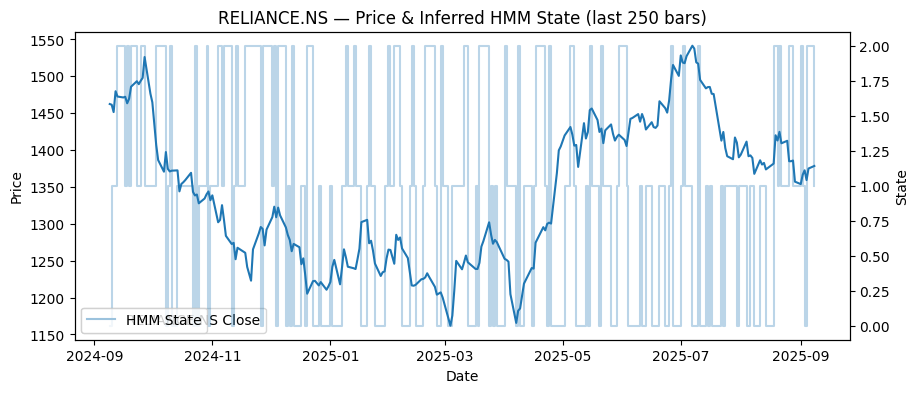

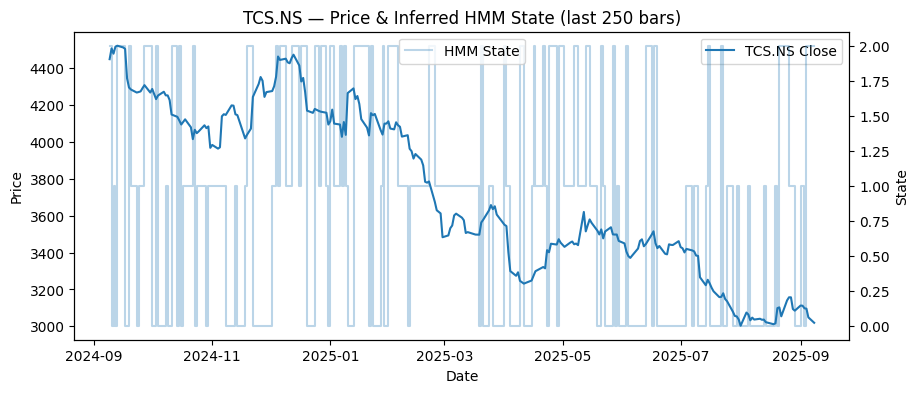

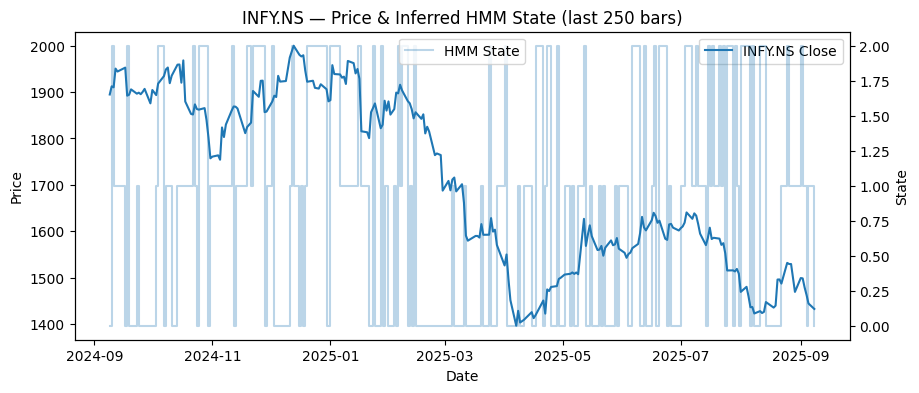

In [36]:

def plot_price_with_states(res: Dict[str, object], last_n: int = 250):
    ohlc = res["ohlc"].copy()
    states = res["states_series"].reindex(ohlc.index).dropna()
    df = ohlc.tail(last_n).copy()
    st = states.tail(last_n).astype(int)

    fig, ax = plt.subplots(figsize=(10, 4))
    ax.plot(df.index, df["Close"], label=f"{res['ticker']} Close")
    ax2 = ax.twinx()
    ax2.plot(st.index, st.values, drawstyle="steps-post", alpha=0.3, label="HMM State")
    ax.set_title(f"{res['ticker']} — Price & Inferred HMM State (last {last_n} bars)")
    ax.set_xlabel("Date")
    ax.set_ylabel("Price")
    ax2.set_ylabel("State")
    ax.legend(loc="best")
    ax2.legend(loc="best")
    plt.show()

if 'results' in globals() and results:
    for i, r in enumerate(results[:5]):
        plot_price_with_states(r, last_n=250)



## 10. How to Adapt / Extend

- **State mapping:** Instead of a single “bull state,” use posterior probabilities to weight MC parameters (soft regime awareness).
- **Backtesting:** Wrap the workflow in a daily loop to generate entries and exits (target/stop/time). Record P&L with costs/slippage.
- **Portfolio:** Combine signals across tickers with volatility-scaling or risk parity to a daily VaR budget.
- **Robust emissions:** Consider Student‑t or heavy‑tail emissions for HMM.
- **Richer MC:** Replace GBM with Merton jump‑diffusion or Heston stochastic volatility.
- **Threshold tuning:** Optimize `P_UP_FIRST_MIN` & `MIN_EXP_RET` via walk‑forward out‑of‑sample tests.
